In [1]:
!pip install tesseract

In [2]:
import os
import sys
import csv
import json
from PIL import Image, ImageFile, ImageSequence, ImageEnhance, ImageChops, ImageFilter, ImageFont, ImageDraw
import pandas as pd
import numpy as np
from pdfminer.high_level import extract_text, extract_text_to_fp
import pytesseract
from logging import Logger
from decimal import *
from functools import lru_cache
from typing import Dict, List
from collections import OrderedDict
from itertools import groupby
from io import BytesIO
from pdfminer.layout import LAParams, LTFigure, LTImage, LTTextContainer
from pdfminer.high_level import extract_pages
from pdfminer.pdftypes import PDFNotImplementedError
import pytesseract
from pdfminer.pdfdocument import PDFDocument
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.pdfpage import PDFPage
from pdfminer.pdfparser import PDFParser
import pymorphy2
import re

import cv2
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

pytesseract.pytesseract.tesseract_cmd = r'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'
tessdata_dir_config = '--psm 12'
morph = pymorphy2.MorphAnalyzer()
ImageFile.LOAD_TRUNCATED_IMAGES = True

Рамки для pytesseract

In [3]:
def get_coordinate(data):

    coordinate = list()
    expansion = 5

    for idx in range(len(data)):

        if data_symb.iloc[idx]['conf'] > 0:

            top = int(data.iloc[idx]['top'])-expansion
            left = int(data.iloc[idx]['left'])-expansion
            width = int(data.iloc[idx]['width'])+expansion*2
            height = int(data.iloc[idx]['height'])+expansion*2

            coordinate.append([[left, top],
                          [left+width, top],
                          [left+width, top+height],
                          [left, top+height],
                          ])

    return coordinate

In [4]:
# Draw bounding boxes
def draw_boxes(image, bounds, color='yellow', width=2):
    image = image.convert('RGB')
    draw = ImageDraw.Draw(image)

    for bound in bounds:
        p0, p1, p2, p3 = bound
        draw.line([*p0, *p1, *p2, *p3, *p0], fill=color, width=width)
    return image

In [8]:
'''img = 'example_transforming.jpg'
im = Image.open(img)  # img is the path of the image
im = im.convert("RGBA")
newimdata = []
datas = im.getdata()

for item in datas:
    if item[0] < 112 or item[1] < 112 or item[2] < 112:
        newimdata.append(item)
    else:
        newimdata.append((255, 255, 255))
im.putdata(newimdata)

im = im.filter(ImageFilter.MedianFilter())
enhancer = ImageEnhance.Contrast(im)
im = enhancer.enhance(2)
im = im.convert('1')
im.save('temp2.jpg')'''

#text = pytesseract.image_to_string(Image.open('example_transforming.jpg'), lang='rus')
#data_symb = pytesseract.image_to_data(Image.open('example_transforming.jpg'), lang='rus')

pd.DataFrame(pytesseract.image_to_data(image_transforming(Image.open('table_without_signature.jpg')), lang='rus').split('\n')).to_csv('data_img_symb.csv')

data_symb = pd.read_csv('data_img_symb.csv', header=1, sep='\t')
data_symb = data_symb.rename(columns={"0,level": "level"})

#проверка level
f = []
for elem in range(len(data_symb)):
    f.append(data_symb['level'].iloc[elem][-1])
    data_symb['level'].iloc[elem] = data_symb['level'].iloc[elem][-1]
pd.Series(f).value_counts()

data_symb

C:\Users\Alina Nazarova\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


level  page_num  block_num  par_num  line_num  word_num    left     top  \
0       1       1.0        0.0      0.0       0.0       0.0     0.0     0.0   
1       2       1.0        1.0      0.0       0.0       0.0   918.0   166.0   
2       3       1.0        1.0      1.0       0.0       0.0   918.0   166.0   
3       4       1.0        1.0      1.0       1.0       0.0   918.0   166.0   
4       5       1.0        1.0      1.0       1.0       1.0   918.0   167.0   
..    ...       ...        ...      ...       ...       ...     ...     ...   
554     5       1.0       11.0      1.0      35.0       4.0  1942.0  3134.0   
555     5       1.0       11.0      1.0      35.0       5.0  2120.0  3134.0   
556     5       1.0       11.0      1.0      35.0       6.0  2165.0  3134.0   
557     5       1.0       11.0      1.0      35.0       7.0  2238.0  3133.0   
558     ,       NaN        NaN      NaN       NaN       NaN     NaN     NaN   

      width  height  conf         text  
0    2480.0  3507.0  -1.0          NaN  
1     817.0    38.0  -1.0          NaN  
2     817.0    38.0  -1.0          NaN  
3     817.0    38.0  -1.0          NaN  
4     255.0    36.0  95.0  Акционерная  
..      ...     ...   ...          ...  
554    75.0    38.0  96.0         270)  
555    31.0    37.0  77.0           {8  
556    60.0    30.0  90.0          960  
557    75.0    38.0  96.0         776)  
558     NaN     NaN   NaN          NaN  

[559 rows x 12 columns]

In [9]:
np.array(data_symb['text'])

array([nan, nan, nan, nan, 'Акционерная', 'компания', '«АЛРОСА»', '(ПАО)',
       nan, nan, nan, 'Бухгалтерская', '(финансовая)', 'отчетность', 'за',
       'год,"', 'закончившийся', '31', 'декабря', '2016', 'г.', nan, nan,
       nan, 'ОТЧЕТ', 'О', 'ДВИЖЕНИИ', 'ДЕНЕЖНЫХ', 'СРЕДСТВ', nan, nan,
       nan, 'за', '2016', 'год', nan, nan, nan, 'Организация', 'АК',
       '«АЛРОСА»', '(ПАО)', nan, 'Идентификационный', 'номер',
       'налогоплательщика', nan, nan, 'Вид', 'деятельности', 'Добыча',
       'алмазов', nan, 'Организационно-правовая', 'форма/форма',
       'собственности', nan, nan, nan, 'публичное', 'акционерное',
       'общество/', 'смешанная', 'российская', 'собственность', 'с', nan,
       'долями', 'федеральной', 'собственности', 'и', 'собственности',
       'субъектов', 'Российской', nan, 'Федерации', nan, nan, nan,
       'Единица', 'измерения:', 'тыс.', 'руб./млн.', 'руб.(ненужное',
       'зачеркнуть)', nan, nan, nan, 'Наименование', 'показателя', nan,
       nan, nan,

In [10]:
get_coordinate(data_symb)

[[[913, 162], [1178, 162], [1178, 208], [913, 208]],
 [[1181, 169], [1378, 169], [1378, 199], [1181, 199]],
 [[1380, 162], [1607, 162], [1607, 201], [1380, 201]],
 [[1610, 161], [1740, 161], [1740, 209], [1610, 209]],
 [[547, 212], [835, 212], [835, 259], [547, 259]],
 [[838, 209], [1100, 209], [1100, 258], [838, 258]],
 [[1103, 217], [1322, 217], [1322, 247], [1103, 247]],
 [[1324, 217], [1369, 217], [1369, 247], [1324, 247]],
 [[1372, 218], [1450, 218], [1450, 255], [1372, 255]],
 [[1452, 210], [1760, 210], [1760, 249], [1452, 249]],
 [[1762, 208], [1810, 208], [1810, 247], [1762, 247]],
 [[1813, 207], [1972, 207], [1972, 254], [1813, 254]],
 [[1974, 206], [2066, 206], [2066, 246], [1974, 246]],
 [[2069, 216], [2105, 216], [2105, 246], [2069, 246]],
 [[763, 298], [946, 298], [946, 343], [763, 343]],
 [[952, 297], [997, 297], [997, 342], [952, 342]],
 [[1001, 296], [1318, 296], [1318, 350], [1001, 350]],
 [[1321, 296], [1643, 296], [1643, 351], [1321, 351]],
 [[1647, 295], [1890, 295]

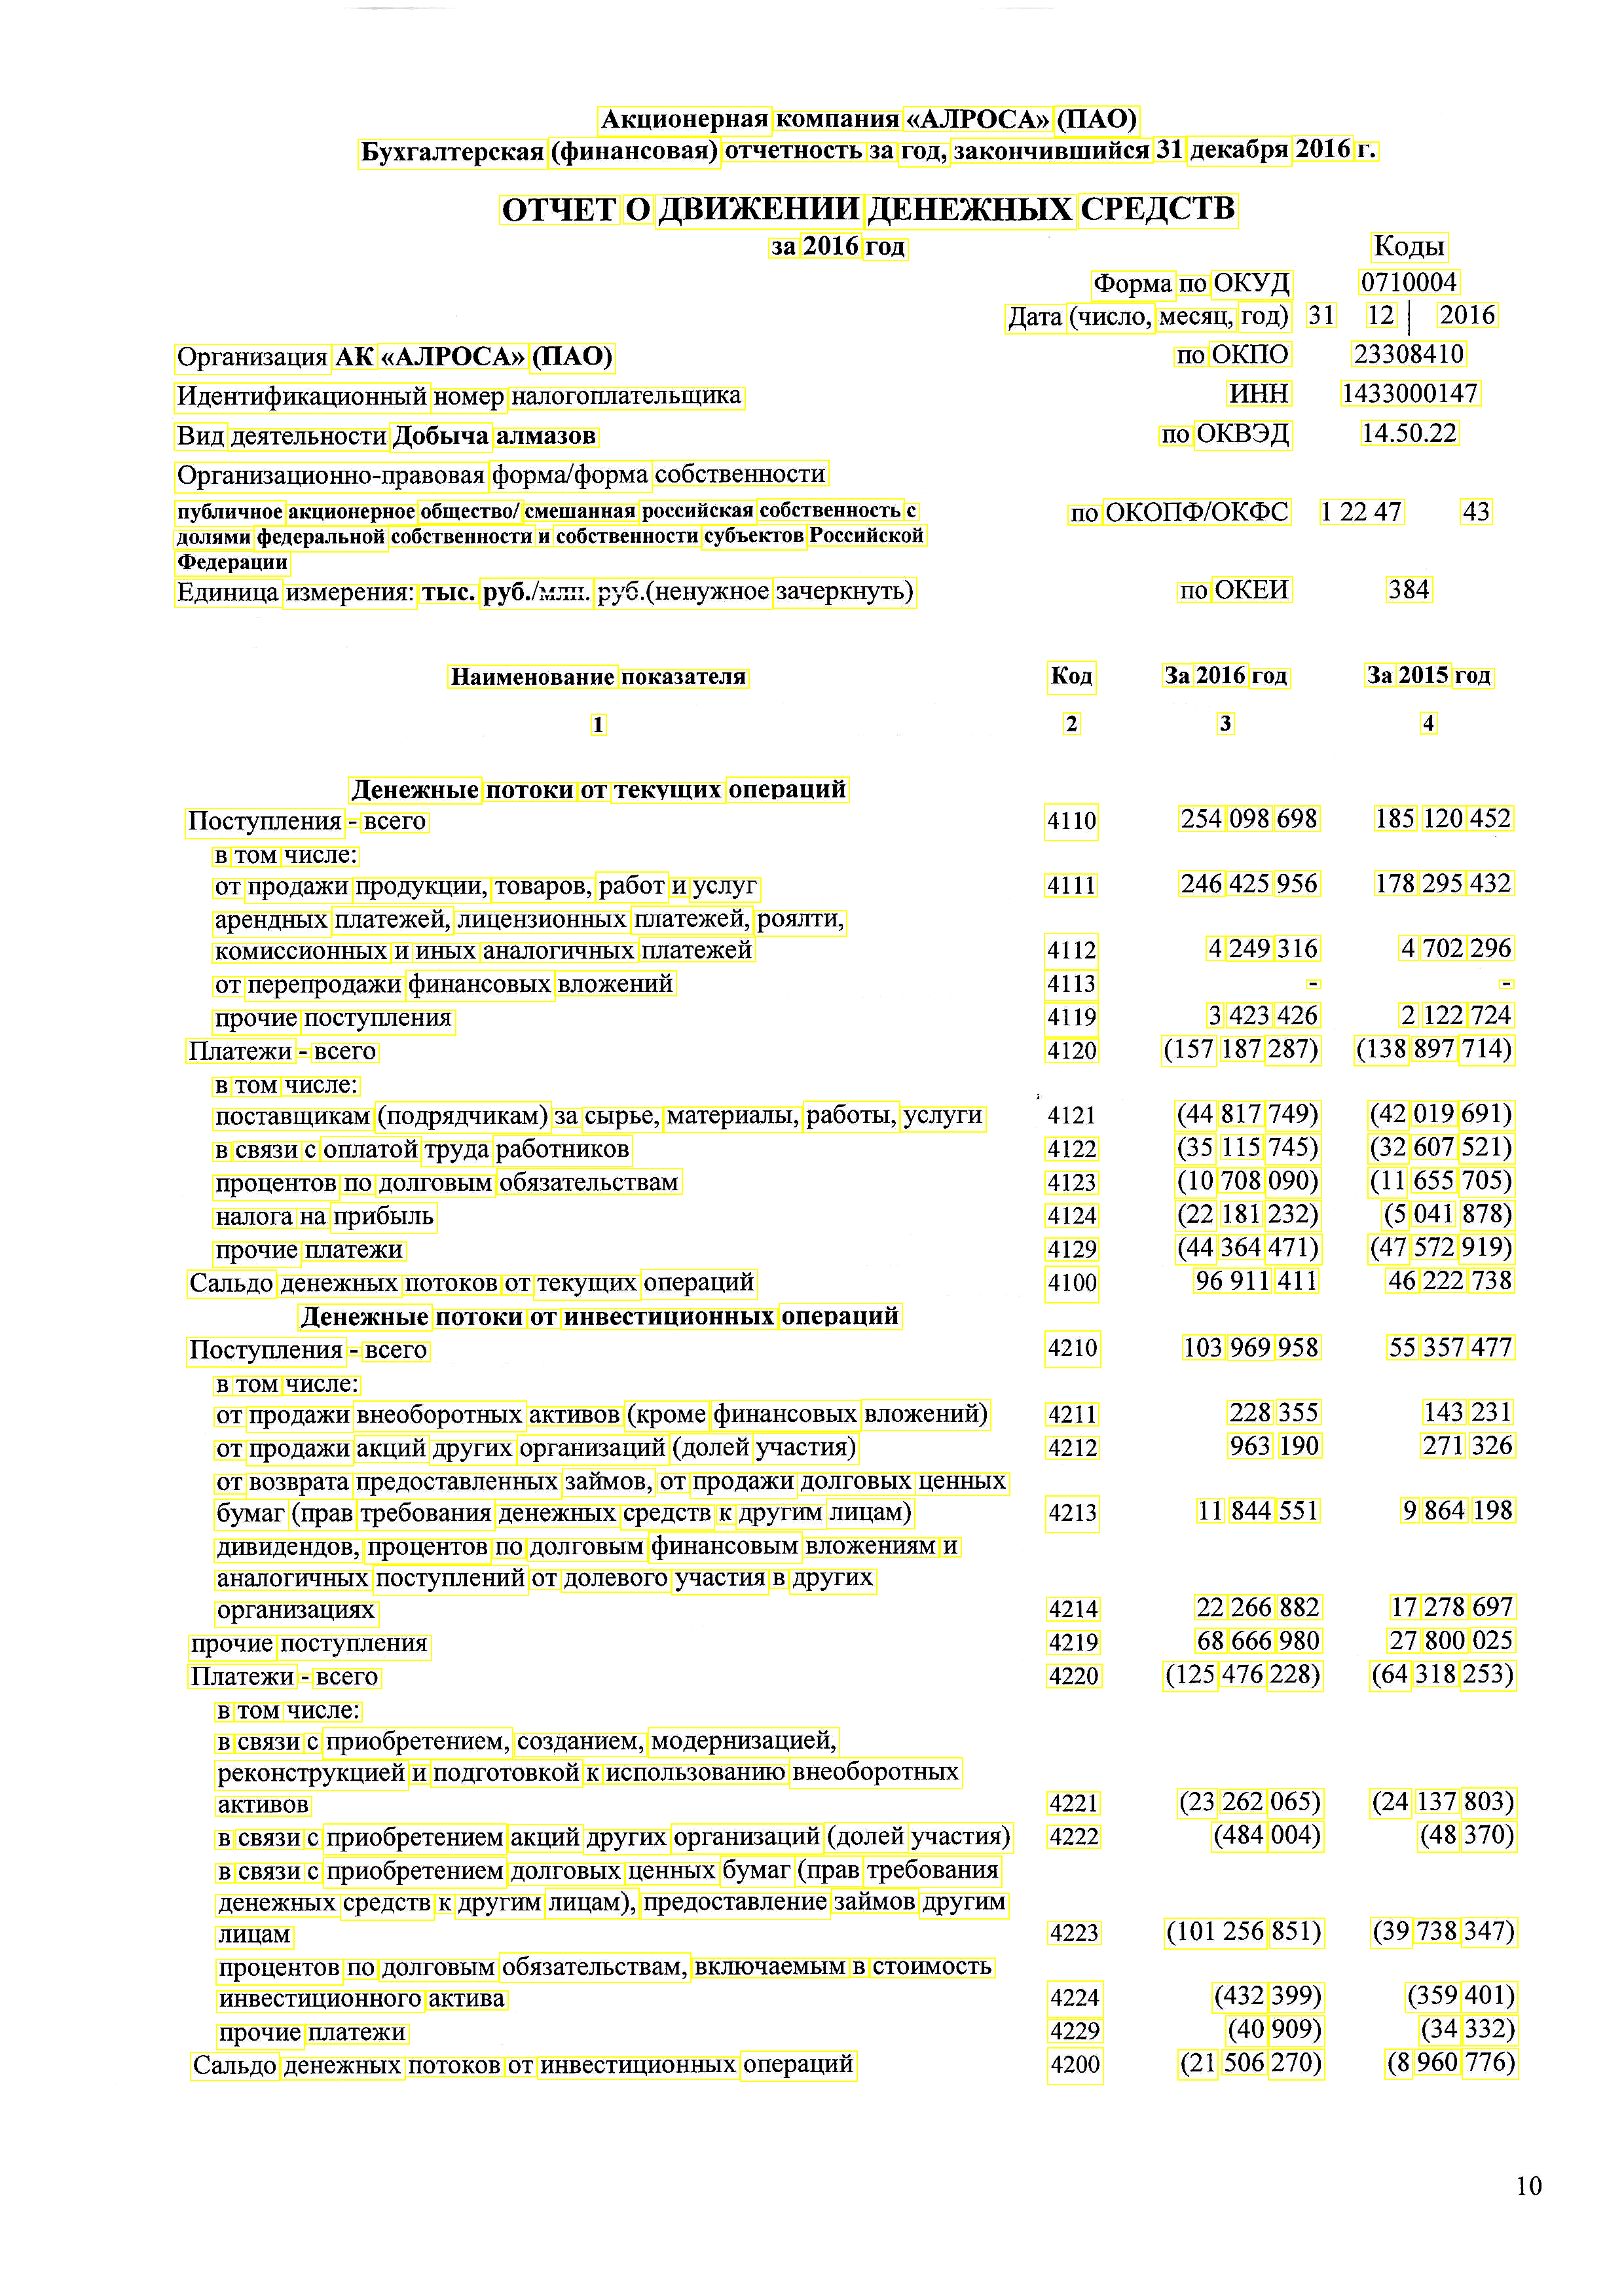

In [11]:
draw_boxes(image_transforming(Image.open('table_without_signature.jpg')), get_coordinate(data_symb))#.save('result_обычный_текст_без_фильтра.jpg')

In [5]:
#для дообучения easyOCR
from tqdm import tqdm

def get_train_data(data, image):

    labels = pd.DataFrame()
    expansion = 5

    for idx in tqdm(range(len(data))):
        if data.iloc[idx]['conf'] > 0.9:

            top = int(data.iloc[idx]['top'])-expansion
            left = int(data.iloc[idx]['left'])-expansion
            width = int(data.iloc[idx]['width'])+expansion*2
            height = int(data.iloc[idx]['height'])+expansion*2

            image.crop((left, top, left+width, top+height)).save('ru_train_filtered/'+str(idx+100)+'.jpg')

            labels = labels.append({'filename': str(idx+100)+".jpg",
                                    'words': data.iloc[idx]['text']},
                                   ignore_index=True)

    return labels

In [13]:
labels = get_train_data(data_symb, Image.open('table_without_signature.jpg'))

100%|██████████| 559/559 [00:01<00:00, 324.33it/s]


In [14]:
labels.to_csv('ru_train_filtered/labels.csv', index=False)

In [16]:
labels.tail()

filename words
439  653.jpg   506
440  654.jpg  270)
441  655.jpg    {8
442  656.jpg   960
443  657.jpg  776)

In [35]:
cd Downloads

C:\Users\Alina Nazarova\Downloads


In [77]:
l = pd.read_csv('..\OneDrive - ООО АЙФЭЛЛ\Рабочий стол\labels.csv')[['filename', 'words']]
l.to_csv('labels.csv', index=False)

In [6]:
import pandas as pd
import os
import openpyxl

In [36]:
#чтение xlxs файлов
df = pd.read_excel(
    os.path.join('labels.xlsx'))

SyntaxError: invalid syntax (__init__.py, line 1187)

IMG from File

In [7]:
def get_images_from_file(
        path_to_file: str,
        logger: Logger,
        groupby_pages: bool=False
): #-> OrderedDict:
    """
    This function converts images from .pdf and returns then as
    PIL instances.
    Args:
        - path_the_file: the path to pdf file
    Returns:
        - the result dict has structure {page.nusber: PIL.Image}
    """
    out = dict()
    out['name'] = path_to_file
    out['pages'] = OrderedDict()
    out['is_image'] = False
    if groupby_pages:
        logger.info('The group by mode ON')
    #it preporates multiple a .tiff file
    if ".tif" in path_to_file[-5:].lower(): #tif --> tiff ???
        with Image.open(path_to_file) as multuple_image:
            for num, img in enumerate(ImageSequence.Iterator(multiple_image)): #получение номера страницы и картинки
                # the line below contains the hardcode in the kye
                # because it is suggested that one page has only one image',
                key = (num, 0) if groupby_pages else (num,)
                #конвертация на выбранной странице картинки
                out["pages"][key] = [img.convert("L")] # сохраняет только оттенки серого, не цвет.

    #it preporates a .pdf file
    elif ".pdf" in path_to_file[-4:].lower():
        for page_num, page_layout in enumerate(extract_pages(path_to_file)):
            for el_num, element in enumerate(page_layout):
                page_key = (page_num, 0) if groupby_pages else (page_num, el_num)
                #it instantiates list
                if out["pages"].get(page_key) is None:
                    out['pages'][page_key] = list()

                #it preporate only LTFigure elements
                if isinstance(element, LTFigure): #элемент - цифровое значение
                    for node in element:
                        img = None
                        #code below preporates an images conventional way
                        #this way suggests that images stores as an image bytestream
                        if hasattr(node, "bits"): #наличие в объекте атрибута
                            try:
                                img = Image.frombytes(
                                    mode=str(node.bits),
                                    data=node.stream.get_data(),
                                    size=node.srcsize,
                                    decoder_name="raw",
                                )
                            except ValueError as err:
                                #this is exception for cases, when an image bytestream contains
                                #an Image as a file
                                logger.warning(
                                    f"\tElement {el_num} on page {page_num} in {path_to_file} has file bytestream."
                                )
                                try:
                                    img = Image.open(BytesIO(node.stream.get_data()))
                                except:
                                    logger.warning(
                                        f"\tElement {el_num} on page {page_num} in {path_to_file} not identificated."
                                    )


                        if img:
                            out["pages"][page_key].append(img.convert("L"))

    #in other cases
    else:
        logger.critical(f"\tFile {path_to_file} has an unsupported type.")

    if sum(list(out["pages"].values()), []):
        out["is_image"] = True
    else:
        out["pages"] = OrderedDict()

    return out

Img2Text

In [8]:
#обрезка изображения
def crop_image(image: Image,
               persent: float):
    return image.crop(box=(0, 0, image.size[0], image.size[1]*persent))

In [14]:
def image_transforming(image: Image): #-> Image:
    """This method transforms images:
    - if image is color it turn it to cray mode
    - if image is gray it enhances image contras, brigteness and sharpness
    - if image is binary it does nothing
    NOTE: in this version transforming params are hardcoded
    """
    # code below does image coverting to gray mode and represents it as np.array and increase Contrast
    image = image.convert("L")
    image = ImageEnhance.Contrast(image).enhance(2) #max-?

    # image = ImageEnhance.Sharpness(image).enhance(2) #нужна ли четкость?
    cv_image = np.array(image) #матрица изображения
    # the lines below instantiate kernels for a base table cleanup and for finish cleanup
    base_kernel = np.array(cv_image).shape[1] // 40 #40?

    # Прямоугольное ядро
    ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, base_kernel)) #размер ядра вертикаль # ядро для отброса шума??
    hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (base_kernel, 1)) #горизонталь
    cleanup_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

    # the code below markup table lines and makes them white
    #пороговое значение для деление на бел/черн цвета #почему не adaptiveThreshold
    inv_bin_image = cv2.threshold(
        (255 - cv_image), 110, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU #OTSU - автоматический выбор порога
    )[1]
    inv_bin_image_vert = cv2.morphologyEx(inv_bin_image, cv2.MORPH_OPEN, ver_kernel) #removing noise
    inv_bin_image_hor = cv2.morphologyEx(inv_bin_image, cv2.MORPH_OPEN, hor_kernel) #removing noise
    inv_bin_table_image = ImageChops.add(
        Image.fromarray(inv_bin_image_vert), Image.fromarray(inv_bin_image_hor) #добавляет два изображения, разделяя результат по масштабу и добавляя смещение
    )

    #увеличение размера элементов
    bolt_inv_bin_table_image = cv2.dilate(
        np.array(inv_bin_table_image), cleanup_kernel, iterations=1
    )
    bolt_inv_bin_table_image = cv2.dilate(
        np.array(bolt_inv_bin_table_image), cleanup_kernel, iterations=1
    )

    return ImageChops.lighter(
        Image.fromarray(cv_image), Image.fromarray(bolt_inv_bin_table_image)
    ) #новое изображение, содержащее более светлые значения

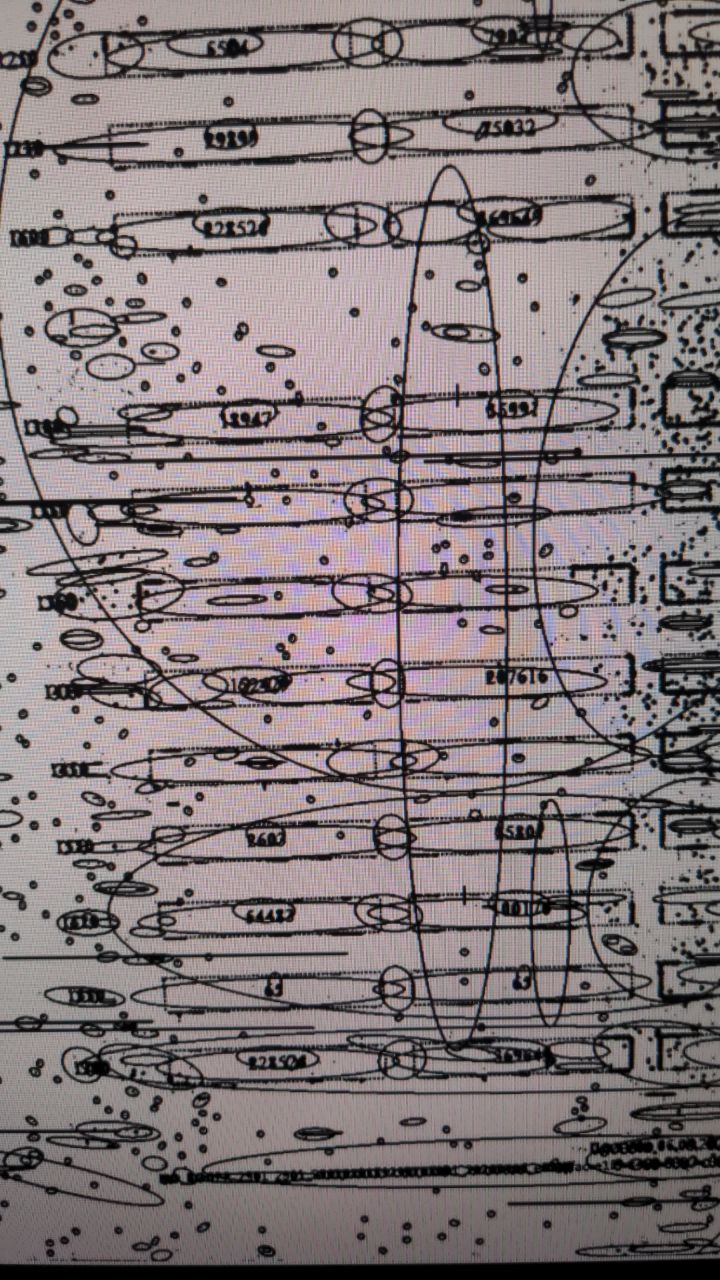

In [11]:
Image.open('noise.jpg')

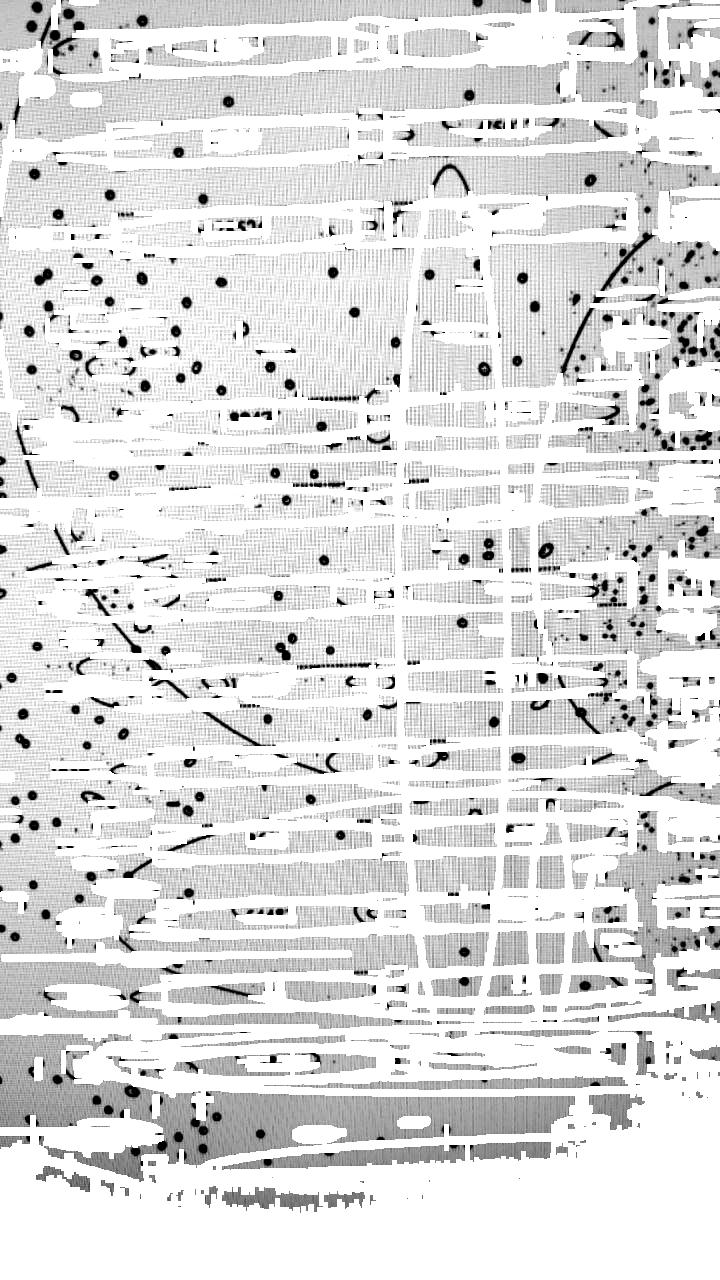

In [15]:
image_transforming(Image.open('noise.jpg'))

In [52]:
def image_to_text(
        image: Image,
        pytesseract_conf: str,
        crop_persent: float,
        lang: str="rus",
        transforming: bool=True,
): #List[List[list]]:
    try:
        osd = pytesseract.image_to_osd(image, output_type=pytesseract.Output.DICT)['orientation']
        if osd != 0:
            image = image.rotate(osd, expand=True)

        img = crop_image(image, crop_persent) if crop_persent < 1 else image
        img = image_transforming(img) if transforming else img

        boxes = pytesseract.image_to_data(
            img,
            config=pytesseract_conf,
            lang=lang,
            output_type=pytesseract.Output.DICT
        )

    except pytesseract.TesseractError as err:
        boxes = {"text": []}

    boxes = [
        (text, boxes["left"][ix], boxes["top"][ix], boxes["conf"][ix], boxes["width"][ix])
        for ix, text in enumerate(boxes["text"]) if int(boxes["conf"][ix]) != 1
    ]
    #print(boxes)
    lines = [sorted(set(sum((list(item) for item in group), [])), key=lambda x: x[1])
             for condition, group in groupby(zip(boxes, boxes[1:]), key=lambda x: (x[1][1] - x[0][1]) >= 0) if condition]

    data = list()

    if lines:
        chars_density = np.array([sum([i[-1]/len(i[0]) if len(i[0]) != 0 else 0 for i in line])/len(line) for line in lines])
        chunk_margin = chars_density.mean() + 3*chars_density.std()

        for ix, line in enumerate(lines):
            distances = [(ix, (p_n[1][1] - (p_n[0][1] + p_n[0][-1]))) for ix, p_n in enumerate(zip(line, line[1:]))]
            distance_group = [(flag, list(group)) for flag, group in groupby(distances, key=lambda x: (x[1] > 0) and (x[1] <= chunk_margin))]
            offsets_groups = [(flag, sorted({ix for ix, d in group}.union({ix + 1 for ix, d in group}))) for flag, group in distance_group]
            already_added = set()
            new_line = list()
            for is_chunk, group in offsets_groups:
                group = list(group)
                if is_chunk:
                    already_added = already_added.union(group)
                    #print(line)
                    new_line.append(
                        (
                            " ".join((line[offset][0] for offset in group)),
                            line[group[0]][1],
                            line[group[0]][2]#,
                            #round(np.array([line[offset][3] for offset in group]).mean())
                        )
                    )

            for is_chunk, group in offsets_groups:
                if not is_chunk:
                    new_line.extend([line[offset] for offset in group if offset not in already_added])
            if new_line:
                data.append(new_line)


    out = list()
    for item in (sorted(item, key=lambda x: x[1]) for item in data):
        out.append([list(chunk[:4]) for chunk in item])

    return out

Realize

In [53]:
img = get_images_from_file('example_2.pdf', logger = Logger(name="my_log"))['pages']

	Element 7 on page 0 in example_2.pdf has file bytestream.
	Element 0 on page 1 in example_2.pdf has file bytestream.
	Element 0 on page 2 in example_2.pdf has file bytestream.
	Element 0 on page 3 in example_2.pdf has file bytestream.
	Element 0 on page 4 in example_2.pdf has file bytestream.
	Element 0 on page 5 in example_2.pdf has file bytestream.
	Element 0 on page 6 in example_2.pdf has file bytestream.
	Element 0 on page 7 in example_2.pdf has file bytestream.
	Element 0 on page 8 in example_2.pdf has file bytestream.
	Element 0 on page 9 in example_2.pdf has file bytestream.
	Element 0 on page 10 in example_2.pdf has file bytestream.
	Element 0 on page 11 in example_2.pdf has file bytestream.
	Element 0 on page 12 in example_2.pdf has file bytestream.
	Element 54 on page 14 in example_2.pdf has file bytestream.
	Element 54 on page 14 in example_2.pdf not identificated.
	Element 18 on page 15 in example_2.pdf has file bytestream.
	Element 18 on page 15 in example_2.pdf not ident

In [160]:
#image_transforming(img[(9, 0)][0]).save('table_without_signature.jpg')

In [161]:
#cv2.imwrite('example_transforming.jpg', img[(10, 0)][0])

In [162]:
#img[(5, 0)][0].rotate(-90, expand=True).save('обычный_текст_без_фильтра.jpg')

In [277]:
for key, value in reversed(img.items()):
    if value != []:
        print(key, "->", value)

AttributeError: 'NoneType' object has no attribute 'items'

In [164]:
tabs = image_to_text(
    image=Image.open('обычный_текст_без_фильтра.jpg'),
    pytesseract_conf=tessdata_dir_config,
    crop_persent=1)

In [165]:
tabs

[[['', 0, 0, '-1'],
  ['ПАО', 645, 279, 96],
  ['', 645, 279, '-1'],
  ['«ГМК «Норильский никель»', 732, 279]],
 [['м!', 277, 331, 24],
  ['', 277, 331, '-1'],
  ['Аудиторское', 643, 326, 78],
  ['', 643, 326, '-1'],
  ['заключение независимых аудиторов', 864, 333]],
 [[' \\А', 255, 344],
  ['1', 255, 344, 61],
  ['', 281, 375, '-1'],
  ['; ', 429, 332],
  ['', 429, 332, '-1'],
  [': ', 483, 349],
  ['з', 505, 327, 36],
  ['Страница', 646, 372, 96],
  ['', 646, 372, '-1'],
  ['5', 818, 374, 96]],
 [['В связи с проведением нами аудита бухгалтерской отчетности', 647, 611],
  ['', 647, 608, '-1'],
  ['наша обязанность', 1882, 620]],
 [['заключается', 644, 668, 96],
  ['', 644, 658, '-1'],
  ['в ознакомлении с прочей информацией,', 895, 669],
  ['когда она станет доступна; и', 1677, 670]],
 [['рассмотрении', 645, 718, 96],
  ['', 645, 718, '-1'],
  ['при этом вопроса, имеются ли существенные несоответствия между',
   922,
   719]],
 [['', 646, 761, '-1'],
  ['прочей', 646, 761, 96],
  ['ин

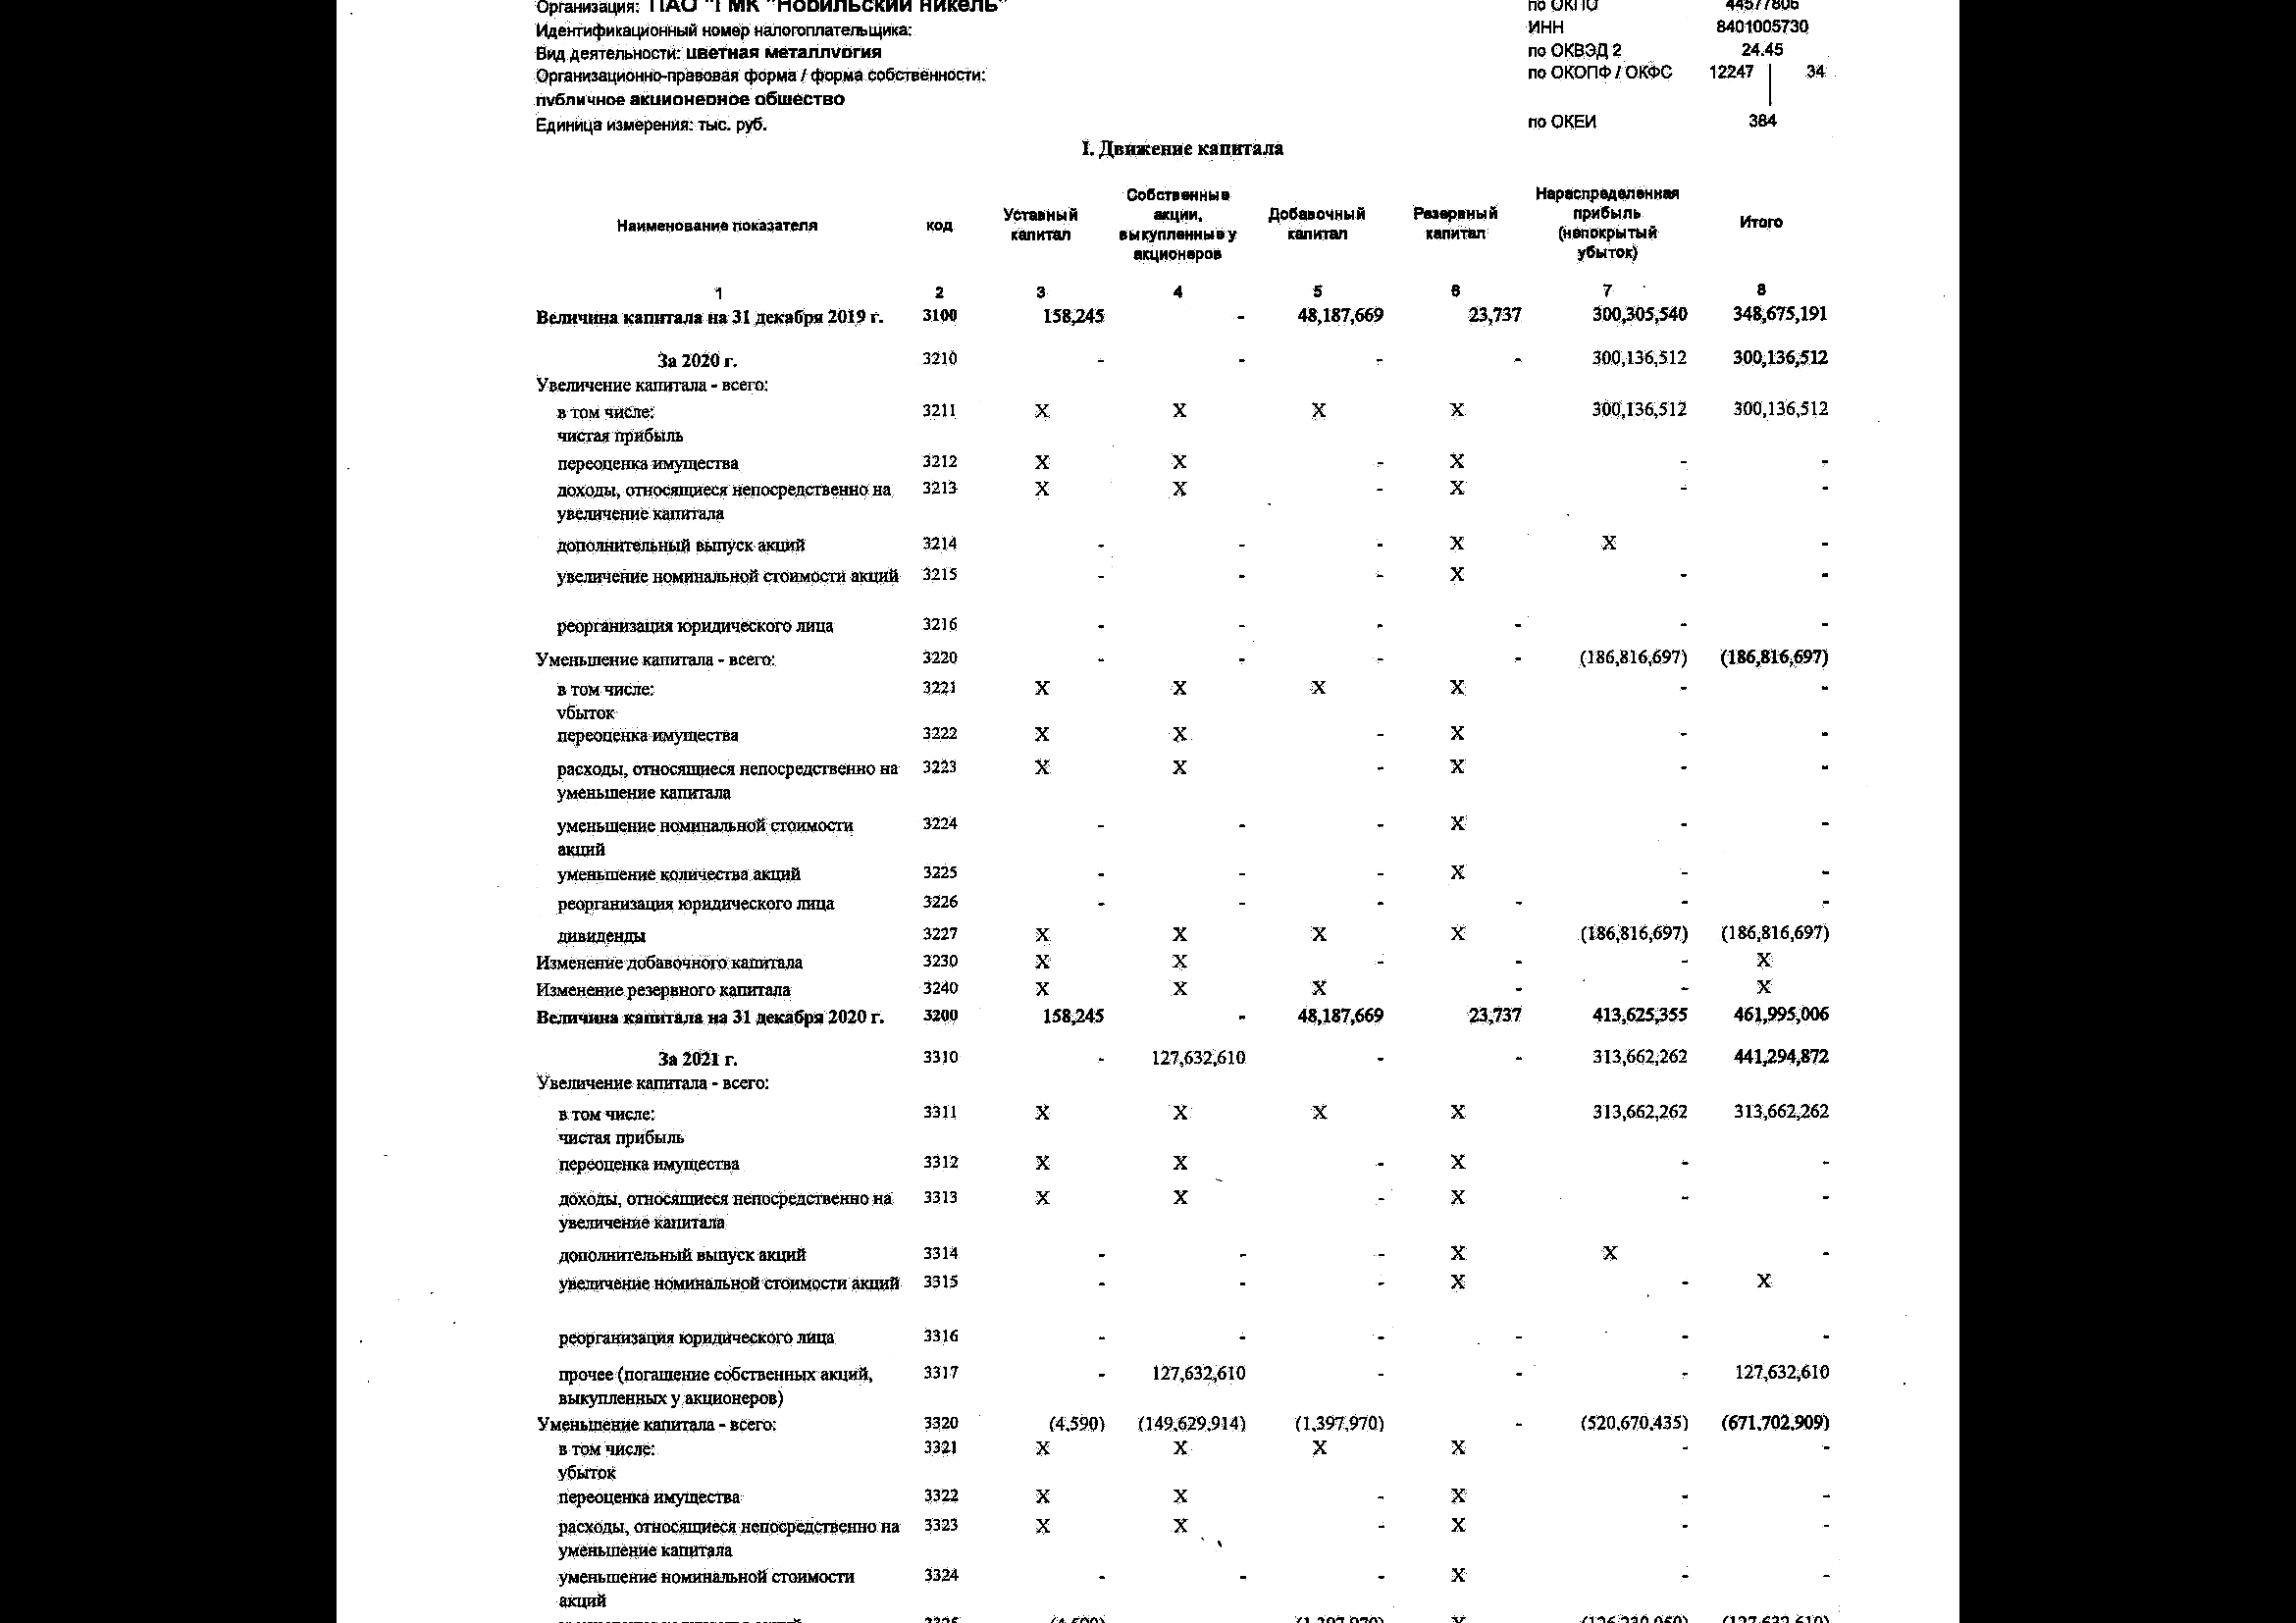

In [280]:
image_transforming(img[(10, 0)][0]).rotate(90)#.save('таблица_без_печати.jpg')

Metrics

In [167]:
#the base constant, they sets up rules for preprocess text values
PUNCT = "!.,:;()-_=""\\/" #+ - ?
DIGIT = "0123456789"
ALPHA = "АаБбВвГгДдЕеЁёЗзЖжИиЙйКкЛлМмНнОоПпРрСсТтУуФфХхЦцЧчШшЩщЪъЫыЬьЭэЮюЯяIV"

In [168]:
def is_significant(token, not_significant_tag: str="UNKN", not_significant_score: float=.7):

    token = morph.parse(token.lower())[0]

    return int((not_significant_tag not in token.tag) & (
            len(token.methods_stack)==1))

def elements_with_significant_tokens(document: list):

    """It solves the significant tokens score.
    The token is significant for NLP if it was recognized by
    the MorphAnalyzer with a rate more or equal to the not_significant_score value
    """

    res = list()
    incorrect_words = list()
    correct_words = list()
    text_str = []
    check_text = []
    text = []

    text_str.extend([elem[0] for tabs_elem in document for elem in tabs_elem if elem[0] != ''])
    check_text.extend([word for text in text_str for word in re.sub(r'\)', ' )', re.sub(r'\(', '( ', re.sub('[^а-яА-ЯЁёIV01234567890\-\=() ]', '', text))).split()])

    for word in check_text:
        try:
            if word[1] == word[1].upper() and word[0] == 'к' and word[-1] == 'к':
                text.append(re.sub('к', '', word, 1)[:-1])
            elif word[1] == word[1].upper() and word[0] == 'к':
                text.append(re.sub('к', '', word, 1))
            else:
                text.append(word)
        except:
            text.append(word)

            continue

    incorrect_words.extend([token for token in text if is_significant(token)==False])
    correct_words.extend([token for token in text if is_significant(token)])

    numbers = sum([is_significant(token) for token in text])

    print("Неверно прочитанные слова: ", incorrect_words)
    #print("Верно прочитанные слова: ", correct_words)
    print("Кол-во подтверженных лемм: ", numbers)
    print("Кол-во найденных лемм: ", len(check_text))

    return "Доля подтвержденных лемм: ", round(numbers/len(check_text), 2)

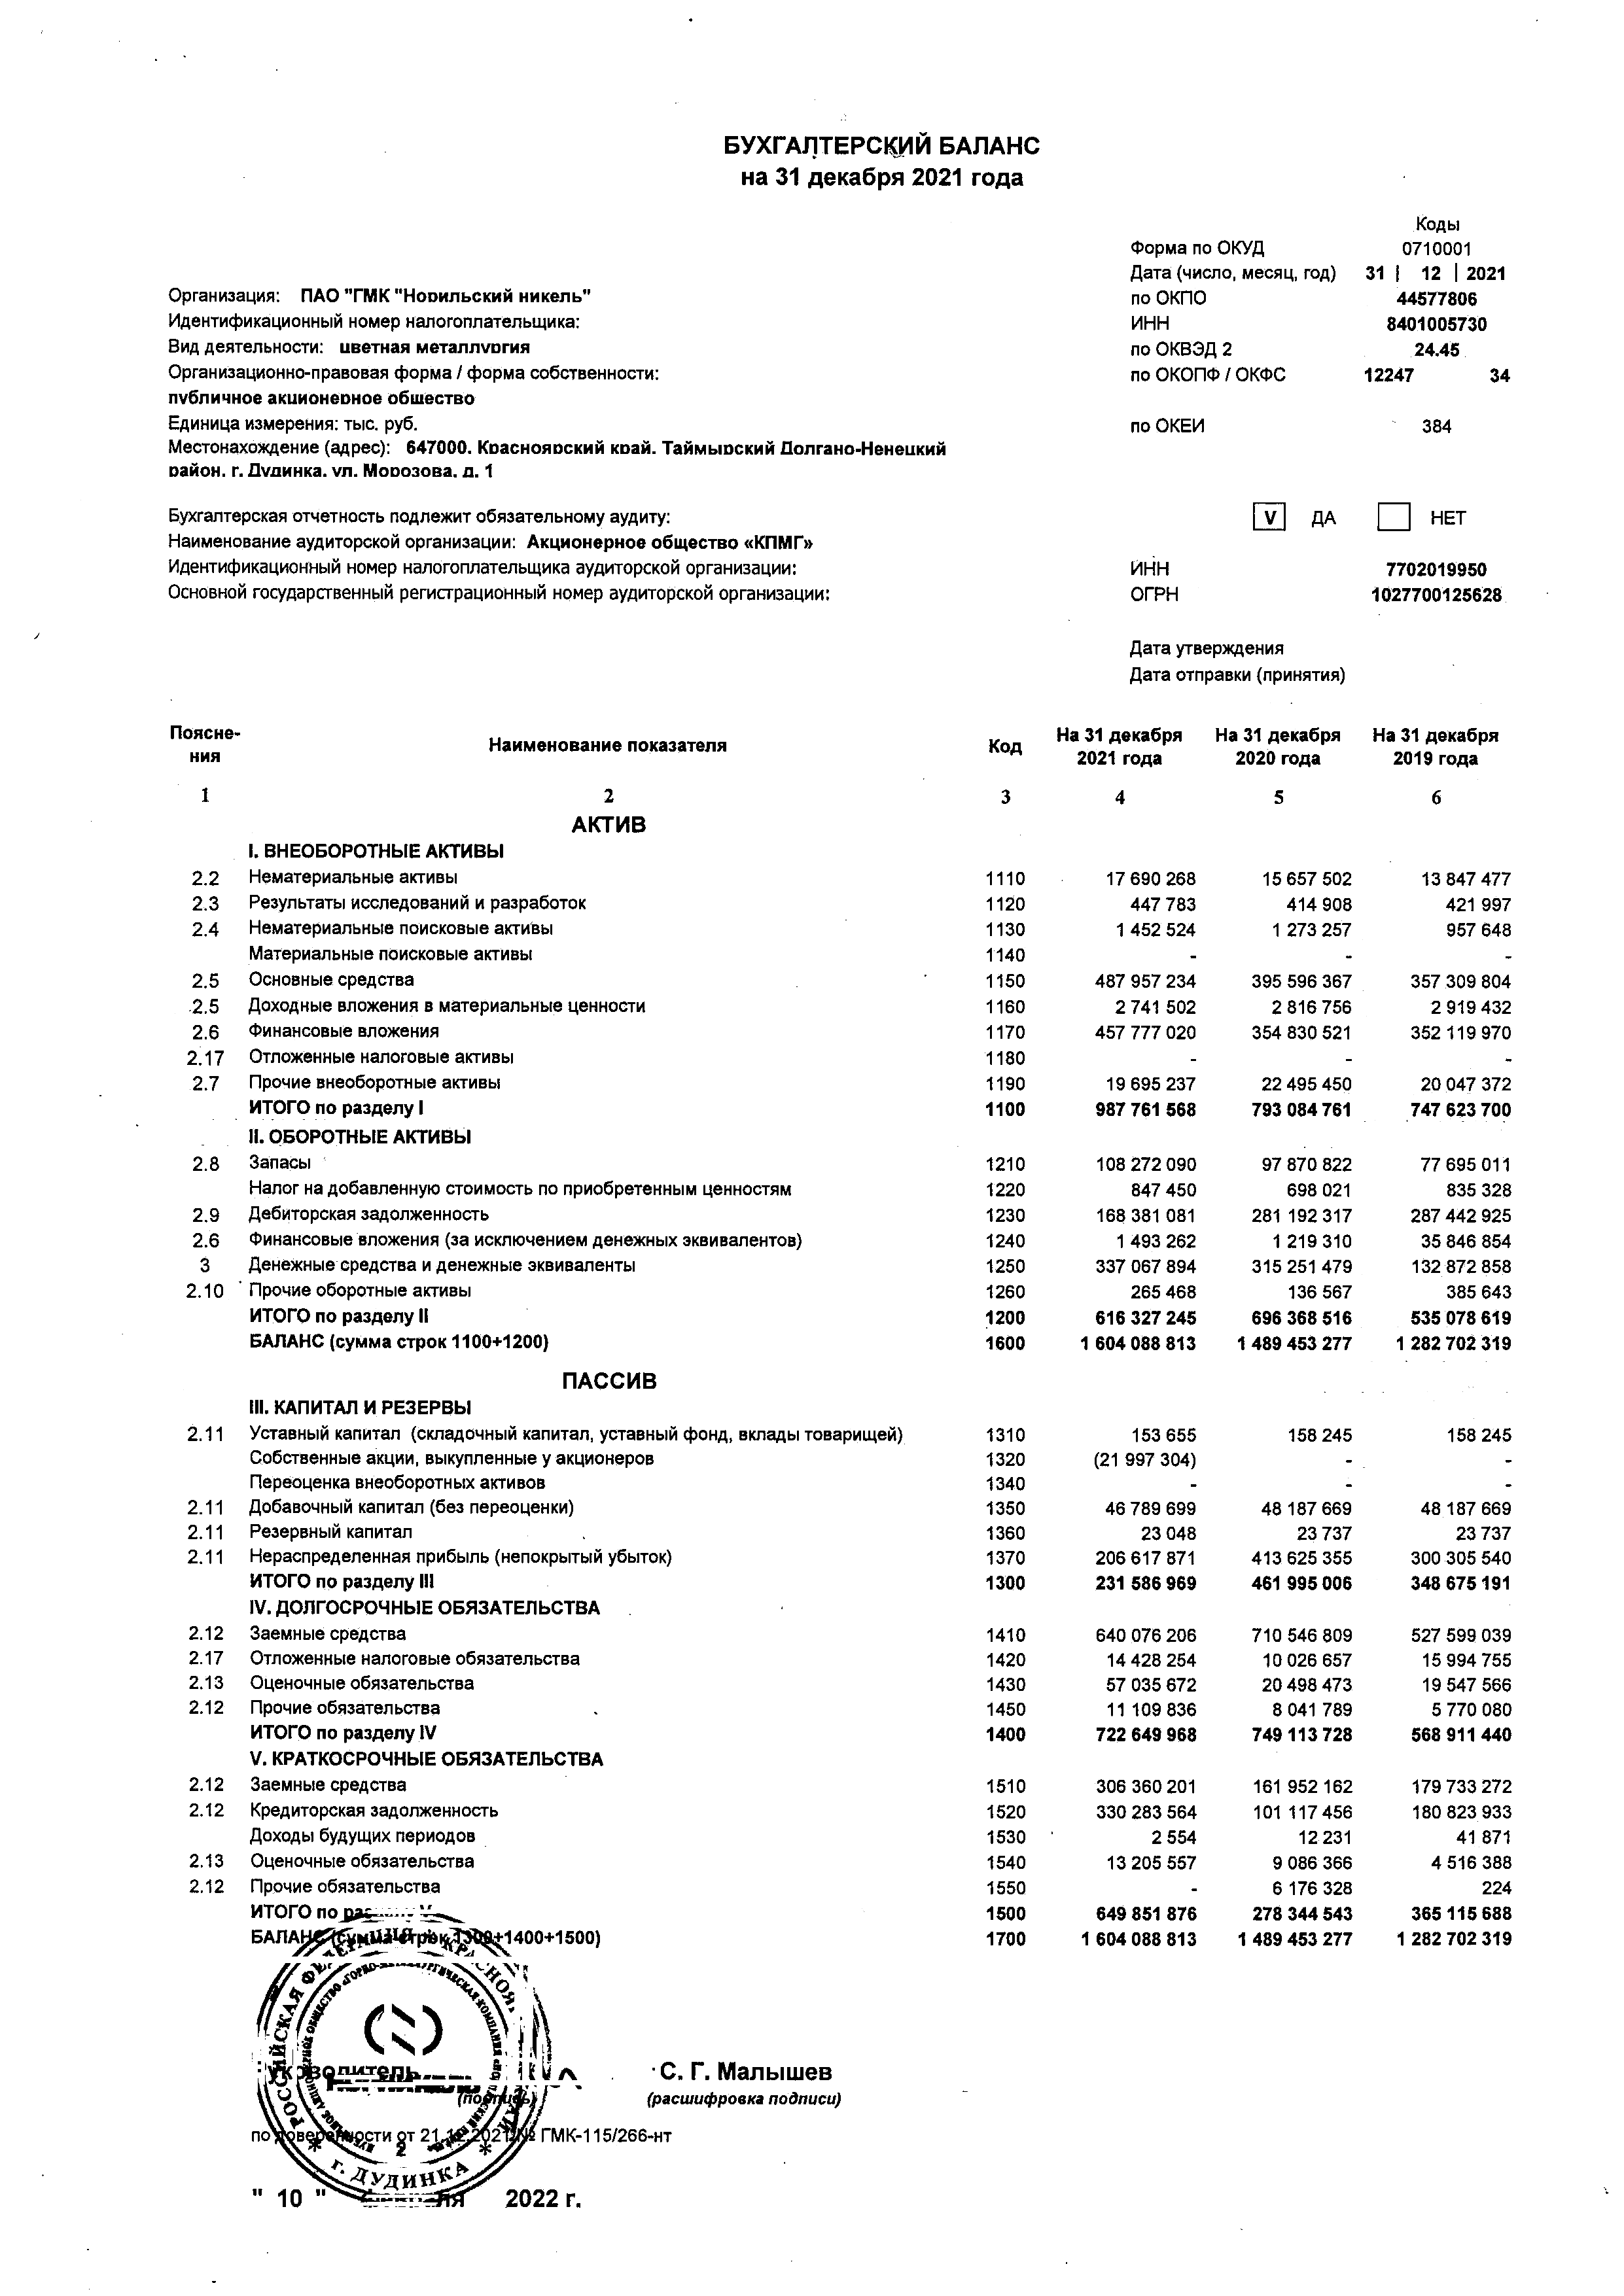

In [298]:
image_transforming(img[(8, 0)][0])

In [291]:
import numpy as np
import cv2


def get_angle(img):
    # сперва переведём изображение из RGB в чёрно серый
    # значения пикселей будут от 0 до 255
    img_gray = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2GRAY)

    # а теперь из серых тонов, сделаем изображение бинарным
    th_box = int(img_gray.shape[0] * 0.007) * 2 + 1
    img_bin_ = cv2.adaptiveThreshold(img_gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, th_box, th_box)

    img_bin = img_bin_
    num_rows, num_cols = img_bin.shape[:2]

    best_zero, best_angle = None, 0
    # итеративно поворачиваем изображение на пол градуса
    for my_angle in range(-20, 21, 1):
        rotation_matrix = cv2.getRotationMatrix2D((num_cols/2, num_rows /2 ), my_angle/2, 1)
        img_rotation = cv2.warpAffine(img_bin, rotation_matrix, (num_cols*2, num_rows*2),
                                      borderMode=cv2.BORDER_CONSTANT,
                                      borderValue=255)

        img_01 = np.where(img_rotation > 127, 0, 1)
        sum_y = np.sum(img_01, axis=1)
        th_ = int(img_bin_.shape[0]*0.005)
        sum_y = np.where(sum_y < th_, 0, sum_y)

        num_zeros = sum_y.shape[0] - np.count_nonzero(sum_y)

        if best_zero is None:
            best_zero = num_zeros
            best_angle = my_angle

        # лучший поворот запоминаем
        if num_zeros > best_zero:
            best_zero = num_zeros
            best_angle = my_angle

    return best_angle * 0.5


img = cv2.imread('try.jpg')
best_angle = get_angle(img)
print(best_angle)

cv2.imshow('Result', img)
cv2.waitKey()

3.0


error: OpenCV(4.5.5) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:1268: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvShowImage'


In [290]:
!pip install opencv-python==4.5.4.60

  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.5.5.64
    Uninstalling opencv-python-4.5.5.64:
      Successfully uninstalled opencv-python-4.5.5.64


In [263]:
#pytesseract
tessdata_dir_config = '--psm 12'
tabs12 = image_to_text(
    image=image_transforming(img[(6, 0)][0]).rotate(267),
    pytesseract_conf=tessdata_dir_config,
    crop_persent=1)
print('12 psm')
elements_with_significant_tokens(tabs12)

12 psm
Неверно прочитанные слова:  ['необнаружения', 'щественного', 'сг', 'овор', 'редставление', 'ствия', 'сис', 'вн', 'обстоятел', 'ьствам', 'ражения', 'эффе', 'КТИВНОСТИ', 'длежащий', 'соответствующег', 'авоме', 'рности', 'деятельнос', 'основани', 'меется', 'услови', 'ями', 'продолжа', 'ТЬ', 'прих', 'одим', 'ЛЖнНыЫ', 'соответств', 'ующему', 'шем', 'раскры', 'тие', 'ключения', 'продо', 'лжать', 'непрерыв', 'представл', 'ения', 'ра', 'ТНоСти', 'ве', 'достов', 'событ', 'ерное', 'предст', 'авление', 'взаимодей', 'управл', 'ствие', 'ние', 'объе', 'ме', 'выявл', 'исле', 'нед', 'яем', 'рпоративное', 'упра', 'вление', 'информи', 'требо', 'ровали', 'Хх', 'основанно', 'оказь', 'необ', 'ходимых', 'вающими', 'угро', 'редпринятых', 'предосторож', 'НОСТИ', 'ц', 'тности', 'ауд', 'ита', 'опи', 'едовательно', 'сл', 'учаев', 'сываем', 'ВОП', 'запрененг', 'гда', 'раскр', 'Мытие', 'инфра']
Кол-во подтверженных лемм:  351
Кол-во найденных лемм:  438


('Доля подтвержденных лемм: ', 0.8)

In [264]:
#pytesseract
tessdata_dir_config = '--psm 4'
tabs4 = image_to_text(
    image=image_transforming(img[(6, 0)][0]).rotate(267),
    pytesseract_conf=tessdata_dir_config,
    crop_persent=1)
print('4 psm')
elements_with_significant_tokens(tabs4)

4 psm
Неверно прочитанные слова:  ['услови', 'прих', 'лЖны', 'ующему', 'соответств', 'непрерыв', 'представл', 'ра', 'достов', 'ауд', 'публ', 'запренень', 'длежащий', 'авомерности', 'меется', 'ями', 'одим', 'ения', 'тности', 'ита', 'воп', 'соответствующег', 'Х', 'шем', 'ключения', 'ТНоСти', 'событ', 'ерное', 'ц', 'едовательно', 'ичное', 'инфон']
Кол-во подтверженных лемм:  172
Кол-во найденных лемм:  204


('Доля подтвержденных лемм: ', 0.84)

In [265]:
tabs12

[[['', 0, 0, '-1'],
  ['', 1293, 64, '-1'],
  ['необнаружения', 1293, 64, 91],
  ['су', 1617, 89, 96],
  ['', 1656, 92, '-1'],
  ['щественного', 1656, 92, 91],
  ['искажен', 1931, 102, 91]],
 [['недобросовестны', 1290, 119, 86],
  ['', 1290, 119, '-1'],
  ['ия', 2083, 115, 96],
  ['', 2083, 115, '-1'],
  ['в', 2163, 119, 95],
  ['результате', 2221, 122, 95],
  ['ошибки', 2464, 129, 92]],
 [['', 1616, 139, '-1'],
  ['е', 1616, 139, 88],
  ['действия', 1670, 143, 95],
  ['мо', 1875, 153, 96],
  ['так', 2647, 145, 89],
  ['', 2647, 145, '-1'],
  ['как', 2744, 152, 89]],
 [['', 1287, 167, '-1'],
  ['пропуск', 1287, 167, 96],
  ['искаженное п', 1454, 180],
  ['гут', 1923, 157, 94],
  ['', 1923, 157, '-1'],
  ['включать', 2009, 161, 91],
  ['сг', 2215, 172, 88],
  ['овор,', 2250, 170, 66],
  ['подлог,', 2383, 182, 89],
  ['', 2383, 182, '-1'],
  ['умышленНый', 2550, 183, 49]],
 [['редставление', 1704, 185, 92],
  ['', 1704, 185, '-1'],
  ['информации или дей', 1974, 204]],
 [['внутреннего ко

In [266]:
tabs4

[[['', 0, 0, '-1'],
  ['—', 1194, 525, 92],
  ['', 1194, 521, '-1'],
  ['оцениваем', 1267, 521, 83],
  ['на', 1521, 535, 79]],
 [['', 1264, 565, '-1'], ['обоснованность', 1264, 565, 96]],
 [['', 1262, 583, '-1'],
  ['', 1614, 583, '-1'],
  ['бухгалтерских', 1614, 583, 96]],
 [['информации, под', 1262, 613], ['', 1262, 613, '-1']],
 [['', 1249, 697, '-1'],
  ['делаем', 1255, 697, 96],
  ['', 1255, 697, '-1'],
  ['вывод', 1430, 706, 64],
  ['о', 1580, 714, 92],
  ['пр', 1638, 717, 94]],
 [['', 1255, 743, '-1'],
  ['непрерывности', 1255, 743, 96],
  ['деятельности,', 1577, 760, 96]],
 [['доказательств', 1249, 793, 90],
  ['', 1249, 793, '-1'],
  ['— вывод о том,', 1527, 820],
  ['и', 1854, 829, 96]],
 [['', 1245, 847, '-1'],
  ['Связи', 1249, 847, 76],
  ['', 1249, 847, '-1'],
  ['с', 1376, 853, 81],
  ['событиями', 1421, 850, 92],
  ['или', 1650, 867, 92],
  ['услови', 1741, 873, 90]],
 [['значительные сомнения в ', 1245, 896],
  ['', 1245, 896, '-1'],
  ['прих', 1775, 975, 87],
  ['', 1

In [198]:
set_tabs12 = list()
set_tabs12.extend([elem[0] for tabs_elem in tabs12 for elem in tabs_elem if elem[0] != ''])

set_tabs4 = list()
set_tabs4.extend([elem[0] for tabs_elem in tabs4 for elem in tabs_elem if elem[0] != ''])

In [199]:
set(set_tabs4).symmetric_difference(set(set_tabs12))

{'  ',
 '(186,816,697) — (186,816,697)',
 '(4,590)',
 '(4.590)',
 '(671,702,909)',
 '.',
 '.;',
 '1.',
 '1. Движение капитала',
 '117457 ГМА ПОБИЛЬСеКИИ НиИкЕЛЬ',
 '2',
 '21',
 '23,137',
 '300,136,51. 2',
 '32',
 '321',
 '3221',
 '3313',
 '`',
 '{671,702,909)',
 'А',
 'Величина капитала на 31 декабря 2019 г.',
 'Величина капитала на 31 декабря 2020 г.',
 'Движение капитала',
 'ЕГО ЫО',
 'Единица',
 'Единица измерения: тыс. руб.',
 'Изменение добавочного капитала',
 'Изменение резервного капитала',
 'Наименование',
 'Наименование показателя',
 'ОКВЭД 2',
 'ОКЕИ',
 'Организационно-правовая',
 'Организационно-правовая форма / форма собственности:',
 'Организация:',
 'Организация: 117457 ГМА ПОБИЛЬСеКИИ НиИкЕЛЬ',
 'Увеличение капитала',
 'Уменьшение капитала - всего:',
 'Хх',
 'ЧЧогЕвУЗ',
 'акции,',
 'акционерное общество',
 'в том числе:',
 'всего:',
 'выкупленные у',
 'выкупленныеу',
 'добавочного капитала',
 'измерения: тыс. руб.',
 'ила Иа',
 'илл ила',
 'имущества,',
 'капитала - всег

In [196]:
tabs12

[[['', 0, 0, '-1'],
  ['', 547, 0, '-1'],
  ['Организация:', 547, 0, 87],
  ['117457 ГМА ПОБИЛЬСеКИИ НиИкЕЛЬ', 663, 0],
  ['па', 1558, 1, 56],
  ['', 1558, 0, '-1'],
  ['мк', 1581, 0, 12],
  ['', 1759, 0, '-1'],
  ['ЕГО ЫО', 1783, 0]],
 [['ИНН', 1559, 21, 86],
  ['', 1559, 21, '-1'],
  ['', 1750, 20, '-1'],
  ['8401005730', 1750, 20, 96]],
 [['Идентификационный', 548, 24, 92],
  ['', 548, 24, '-1'],
  ['номер налогоплательщика:', 716, 27]],
 [['Вид', 547, 48, 95],
  ['', 547, 48, '-1'],
  ['деятельности: цветная металлургия', 581, 50],
  ['по', 1558, 48, 96],
  ['', 1558, 44, '-1'],
  ['ОКВЭД 2', 1581, 44],
  ['', 1776, 44, '-1'],
  ['24.45', 1776, 44, 96]],
 [['по ОКОПФ / ОКФС', 1558, 70],
  ['', 1558, 66, '-1'],
  ['12247', 1743, 66, 96],
  ['', 1743, 66, '-1'],
  ['', 1842, 66, '-1'],
  ['34', 1842, 66, 96]],
 [['Организационно-правовая', 547, 70, 47],
  ['', 547, 69, '-1'],
  ['форма / форма собственности:', 759, 70]],
 [['публичное', 547, 95, 96],
  ['', 547, 93, '-1'],
  ['акцион

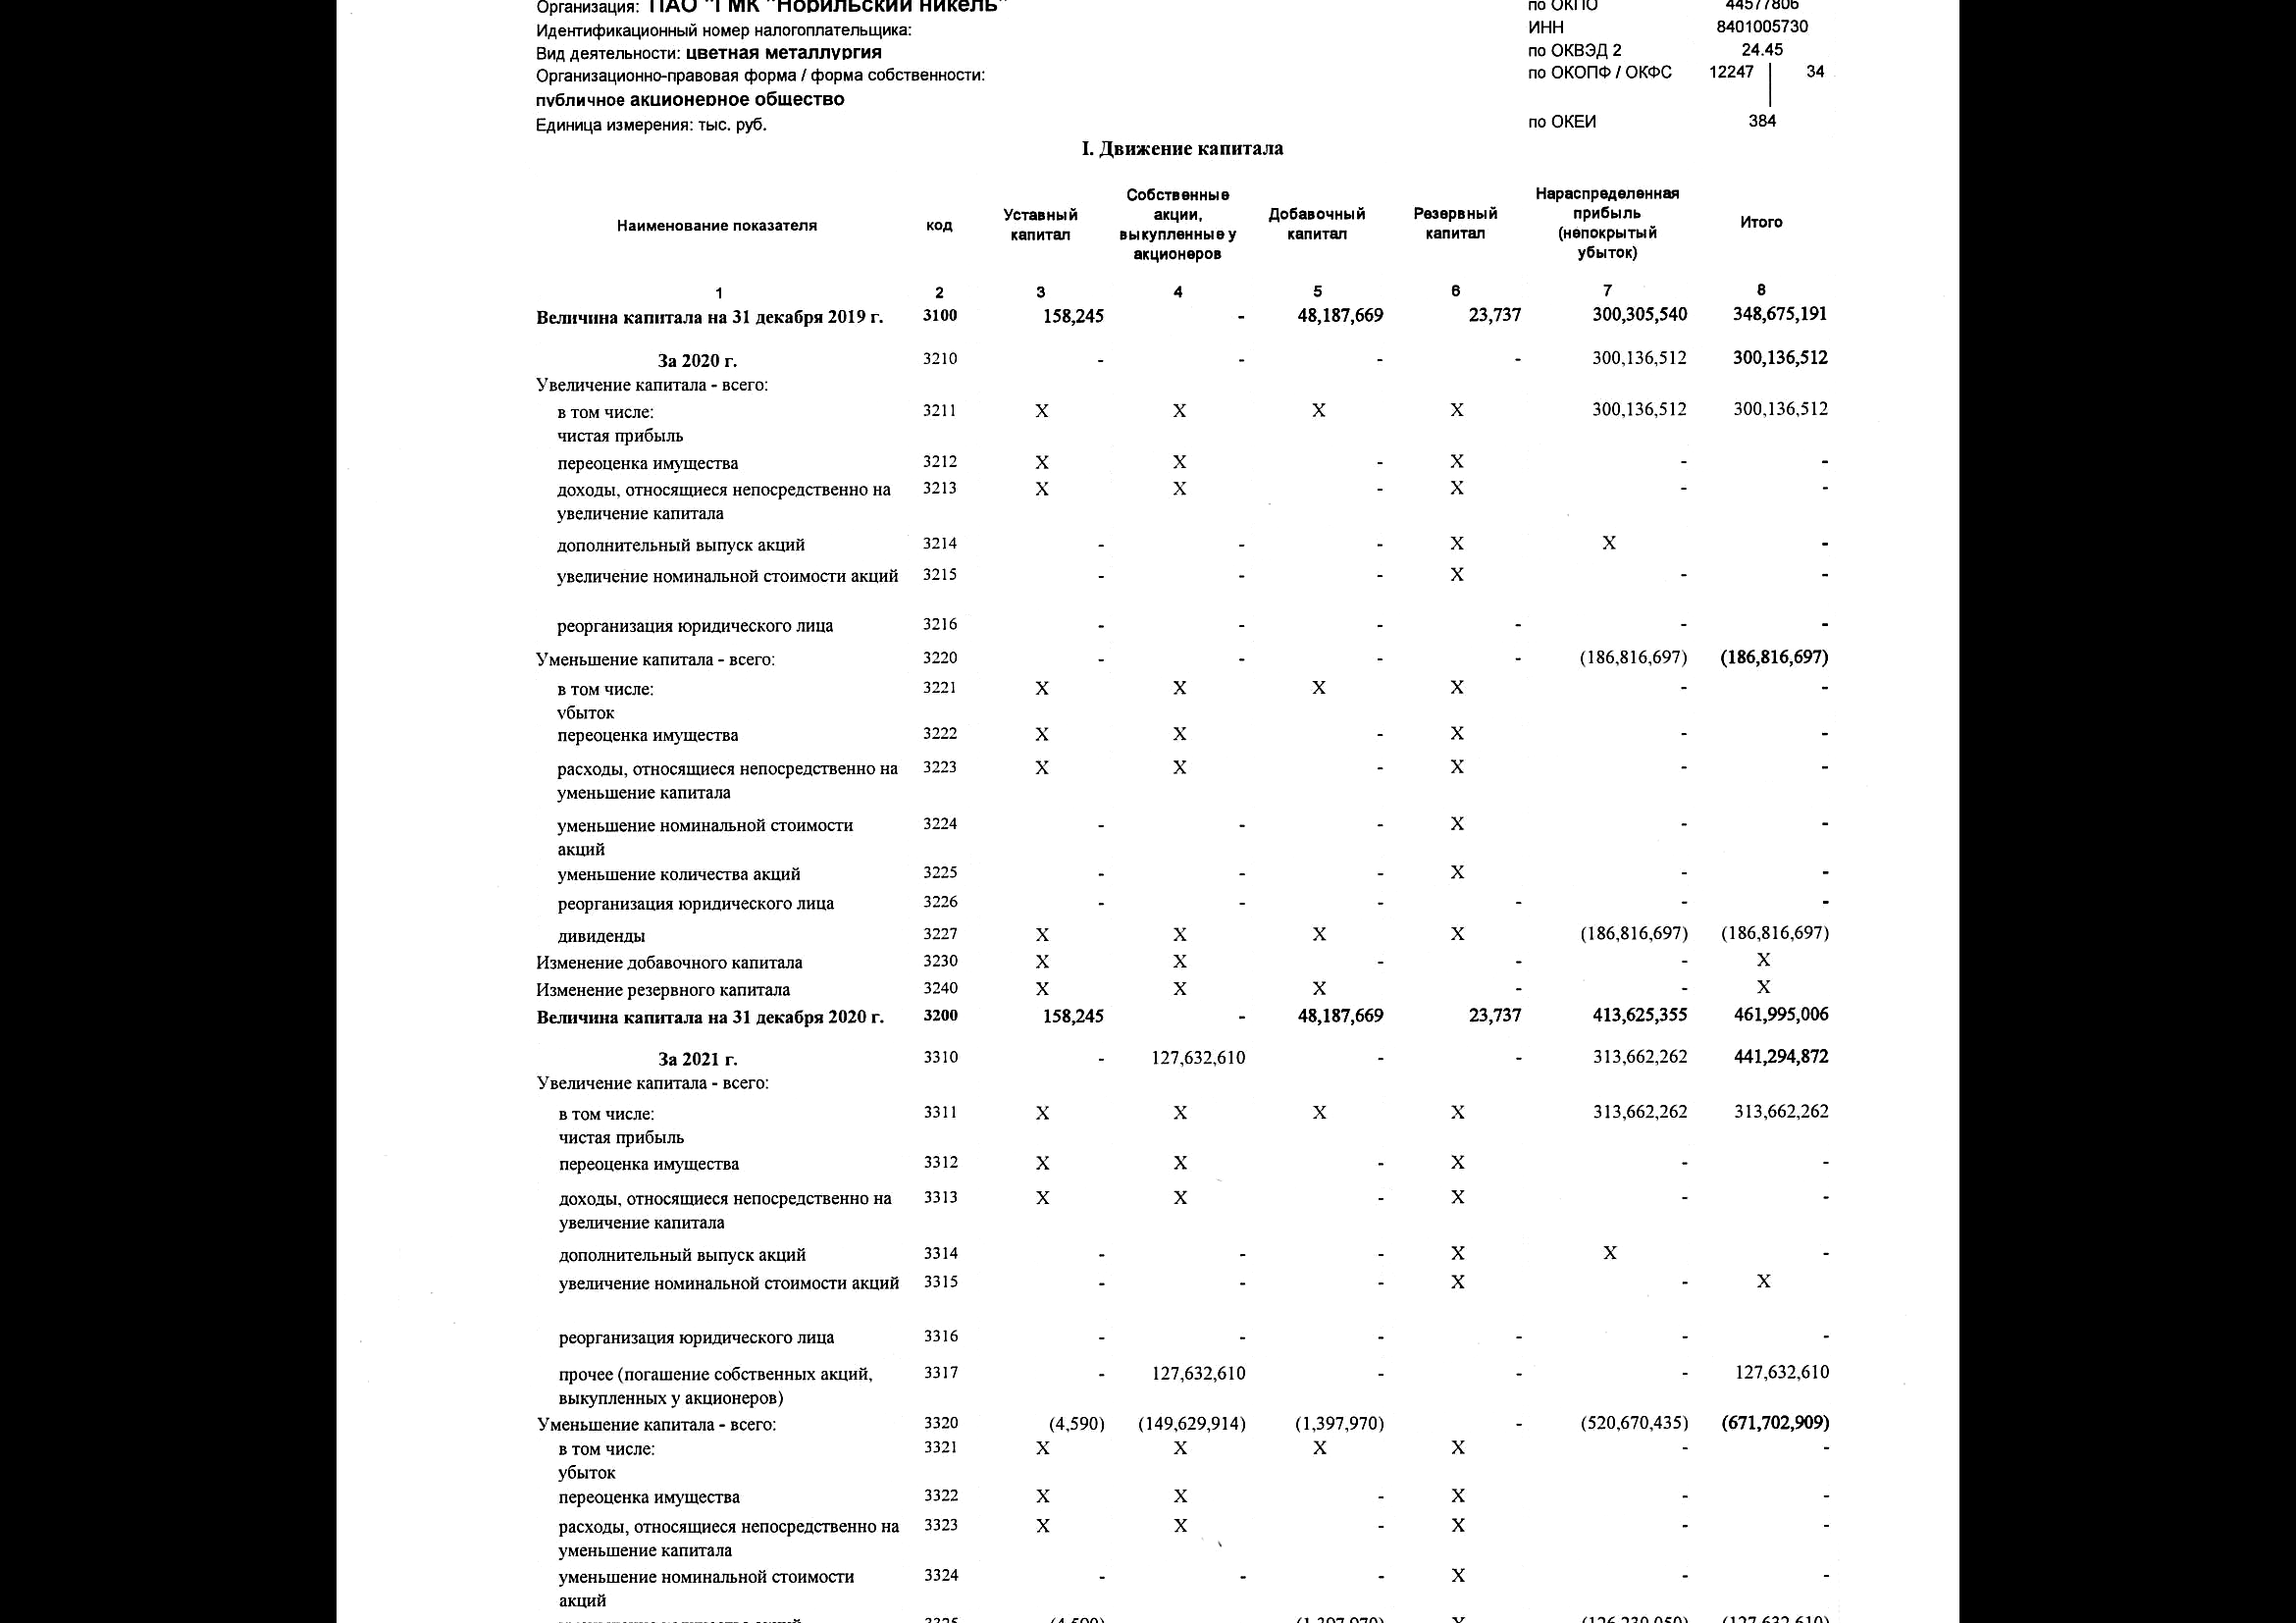

In [195]:
image_transforming(img[(10, 0)][0]).rotate(90)

Рамки для pytesseract

In [174]:
'''#рамки
import cv2
import pytesseract
from pytesseract import Output

img = get_images_from_file('example_3.pdf', logger = Logger(name="my_log"))['pages']
img = img[(8, 0)][0]
img = img.convert("L")
img = ImageEnhance.Contrast(img).enhance(5)

d = pytesseract.image_to_data(img, output_type=Output.DICT)
print(d.keys())

from tqdm import tqdm
n_boxes = len(d['text'])
for i in tqdm(range(n_boxes)):
    if int(d['conf'][i]) > 60:
        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
        img = np.array(img)
        img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

Image.fromarray(img)'''

'#рамки\nimport cv2\nimport pytesseract\nfrom pytesseract import Output\n\nimg = get_images_from_file(\'example_3.pdf\', logger = Logger(name="my_log"))[\'pages\']\nimg = img[(8, 0)][0]\nimg = img.convert("L")\nimg = ImageEnhance.Contrast(img).enhance(5)\n\nd = pytesseract.image_to_data(img, output_type=Output.DICT)\nprint(d.keys())\n\nfrom tqdm import tqdm\nn_boxes = len(d[\'text\'])\nfor i in tqdm(range(n_boxes)):\n    if int(d[\'conf\'][i]) > 60:\n        (x, y, w, h) = (d[\'left\'][i], d[\'top\'][i], d[\'width\'][i], d[\'height\'][i])\n        img = np.array(img)\n        img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)\n\nImage.fromarray(img)'

In [176]:
'''import os
import sys

import requests
import table_ocr.util
import table_ocr.extract_tables
import table_ocr.extract_cells
import table_ocr.ocr_image
import table_ocr.ocr_to_csv
def download_image_to_tempdir(url, filename=None):
    if filename is None:
        filename = os.path.basename(url)
    response = requests.get(url, stream=True)
    tempdir = table_ocr.util.make_tempdir("demo")
    filepath = os.path.join(tempdir, filename)
    with open(filepath, 'wb') as f:
        for chunk in response.iter_content():
            f.write(chunk)
    return filepath

def main(url):
    image_filepath = download_image_to_tempdir(url)
    image_tables = table_ocr.extract_tables.main([image_filepath])
    print("Running `{}`".format(f"extract_tables.main([{image_filepath}])."))
    print("Extracted the following tables from the image:")
    print(image_tables)
    for image, tables in image_tables:
        print(f"Processing tables for {image}.")
        print(tables)
        for table in tables:
            print(f"Processing table {table}.")
            cells = table_ocr.extract_cells.main(table)
            ocr = [
                table_ocr.ocr_image.main(cell, None)
                for cell in cells
            ]
            print("Extracted {} cells from {}".format(len(ocr), table))
            print("Cells:")
            for c, o in zip(cells[:3], ocr[:3]):
                with open(o) as ocr_file:
                    # Tesseract puts line feeds at end of text.
                    # Stript it out.
                    text = ocr_file.read().strip()
                    print("{}: {}".format(c, text))
            # If we have more than 3 cells (likely), print an ellipses
            # to show that we are truncating output for the demo.
            if len(cells) > 3:
                print("...")
            return table_ocr.ocr_to_csv.text_files_to_csv(ocr)

if __name__ == "__main__":
    csv_output = main('https://raw.githubusercontent.com/eihli/image-table-ocr/master/resources/examples/example-page-table-000.png')
    print()
    print("Here is the entire CSV output:")
    print()
    print(csv_output)'''

Running `extract_tables.main([C:\Users\ALINAN~1\AppData\Local\Temp\demo_jz10c7k4\example-page-table-000.png]).`
Extracted the following tables from the image:
[('C:\\Users\\ALINAN~1\\AppData\\Local\\Temp\\demo_jz10c7k4\\example-page-table-000.png', ['C:\\Users\\ALINAN~1\\AppData\\Local\\Temp\\demo_jz10c7k4\\example-page-table-000\\table-000.png'])]
Processing tables for C:\Users\ALINAN~1\AppData\Local\Temp\demo_jz10c7k4\example-page-table-000.png.
['C:\\Users\\ALINAN~1\\AppData\\Local\\Temp\\demo_jz10c7k4\\example-page-table-000\\table-000.png']
Processing table C:\Users\ALINAN~1\AppData\Local\Temp\demo_jz10c7k4\example-page-table-000\table-000.png.


TesseractError: (1, 'Error opening data file C:UsersAlina/table-ocr.traineddata Please make sure the TESSDATA_PREFIX environment variable is set to your "tessdata" directory. Failed loading language \'table-ocr\' Tesseract couldn\'t load any languages! Could not initialize tesseract.')

Meta from PDF

In [177]:
def get_text_elements_from_pdf(
        path_to_file: str,
        logger: Logger,
        laparams: dict = {
            "line_overlap": 0.5 ,
            "char_margin": 2.0,
            "line_margin": 0.5,
            "word_margin": 0.1,
            "boxes_flow": 0.5,
            "detect_vertical": False,
            "all_texts": False,
        },
): # -> Dict:
    # комментарии в картинке 2
    out = dict()
    out["name"] = path_to_file
    out["pages"] = OrderedDict()
    out["is_text"] = False
    if ".pdf" in path_to_file[-4:].lower():
        round_y = (
            lambda val: int(Decimal(val).quantize(Decimal(1.0), rounding=ROUND_DOWN)) #1 знак после запятой
            if val < 100
            else val // 10
        )
        for page_num, page_layout in enumerate(
            extract_pages(path_to_file, laparams=LAParams(**laparams))
        ):
            # the line below performs the rounding, the sorting and the filtering tp provide
            # the right way for a text elements arranding
            boxes = [
                (
                    element.get_text(),
                    element.x0,
                    element.y1, #y1 -
                    100 #зачем ?? q
                )
                for element in page_layout if isinstance(element, LTTextContainer)
            ] #раскладка по элементам

            if boxes:
                max_y = max(boxes, key=lambda x: x[2])[2]
                # начало координат по умолчанию(левый нижний угол)
                # начало координат - верхний левый угол смещенный на начало первых строк
                #текст / ширина / высота / q
                boxes = [[text, round(x), round(max_y - y), q] for text, x, y, q, in boxes]

                tmp = [
                    sorted((item for item in group[1] if "\\x" not in item[0]), key=lambda x: x[1]) #\\x - ? #группировка по ширине
                    for group in groupby(boxes, key=lambda x: x[2]//10 if x[2] >= 100 else int(x[2])) #groupby - Collections/Intertools? группировка по высоте
                ]
                out["pages"][page_num] = sorted(tmp, key=lambda x: x[0][2]) #по высоте первого элемента

    if out["pages"]:
        out["is_text"] = True

    return out

In [178]:
get_text_elements_from_pdf('first.pdf', logger=Logger(name='my_log'))

{'name': 'first.pdf',
 'pages': OrderedDict([(0,
               [[['УТВЕРЖДЕН \nРЕШЕНИЕМ ЕДИНСТВЕННОГО АКЦИОНЕРА  \nЗАО «ТРАНСМАШХОЛДИНГ» \nКомпанией Брейкерс Инвестментс Б.В.  \n(The Breakers Investments B.V.) \n \n',
                  299,
                  0,
                  100]],
                [['РЕШЕНИЕ ОТ «13» СЕНТЯБРЯ 2011 г. \n \n', 322, 82, 100]],
                [['У С Т А В  \n', 272, 234, 100]],
                [['З А К Р Ы Т О Г О   А К Ц И О Н Е Р Н О Г О  \nО Б Щ Е С Т В А  \n«Т Р А Н С М А Ш Х О Л Д И Н Г » \n( р е д а к ц и я   № 5 )  \n',
                  141,
                  293,
                  100]],
                [['г. Москва, 2011 г. \n', 272, 664, 100]],
                [['1 \n', 317, 722, 100], [' \n', 553, 722, 100]],
                [[' \n \n \n', 85, 736, 100]],
                [[' \n', 499, 739, 100]]]),
              (1,
               [[[' \n', 549, 0, 100]],
                [[' \n', 85, 0, 100]],
                [[' \nГлава I. ОБЩИЕ ПОЛОЖЕНИЯ

In [179]:
#1-12 стр - изображения
get_text_elements_from_pdf('example_2.pdf', logger=Logger(name='my_log'))

{'name': 'example_2.pdf',
 'pages': OrderedDict([(0,
               [[[' \n', 399, 0, 100]],
                [['ГОРНО-МЕТАЛЛУРГИЧЕСКАЯ КОМПАНИЯ \nПУБЛИЧНОЕ АКЦИОНЕРНОЕ ОБЩЕСТВО \n \n \n',
                  198,
                  11,
                  100]],
                [[' \n \n \n \n \n \n \n', 71, 64, 100]],
                [['ГОДОВАЯ \nБУХГАЛТЕРСКАЯ (ФИНАНСОВАЯ) \nОТЧЕТНОСТЬ \nПАО «ГМК «НОРИЛЬСКИЙ НИКЕЛЬ» \n \nза 2021 год \n',
                  82,
                  167,
                  100]],
                [[' \n \n', 71, 324, 100]],
                [[' \n', 138, 339, 100]]]),
              (13,
               [[[' \n \n \n \n', 85, 0, 100]],
                [['ПАО «ГМК «НОРИЛЬСКИЙ НИКЕЛЬ» \n \n \n \n \nПОЯСНЕНИЯ  \nК БУХГАЛТЕРСКОЙ (ФИНАНСОВОЙ) \nОТЧЕТНОСТИ  \nза 2021 год\n',
                  130,
                  65,
                  100]],
                [[' \n', 553, 758, 100]]]),
              (14,
               [[['2021 \n', 500, 0, 100]],
                [[' \n',

In [180]:
get_text_elements_from_pdf('example_3.pdf', logger=Logger(name='my_log'))

{'name': 'example_3.pdf',
 'pages': OrderedDict([(0,
               [[[' \n \n', 92, 0, 100]],
                [['Акционерная компания «АЛРОСА» \n(публичное акционерное общество)  \n \nАудиторское заключение  \nо бухгалтерской отчетности \n2016 год  \n \n',
                  92,
                  136,
                  100]],
                [[' \n', 92, 774, 100]]]),
              (1,
               [[[' \n', 99, 0, 100]],
                [['Аудиторское заключение \n \n \nАкционерам Акционерной компании «АЛРОСА» (публичное акционерное общество): \n',
                  99,
                  128,
                  100]],
                [[' \n', 99, 186, 100]],
                [['Аудируемое лицо \n', 99, 206, 100]],
                [['Акционерная компания «АЛРОСА» (публичное акционерное общество). \n',
                  99,
                  226,
                  100]],
                [['Свидетельство о государственной регистрации акционерного общества № 1 выдано \nАдминистрацией Мирн

In [181]:
elems = get_text_elements_from_pdf('first.pdf', logger=Logger(name='my_log'))

In [182]:
def objective(trial):

    reader = easyocr.Reader(["ru", "en"])
    image = 'обычный_текст_без_фильтра.jpg'

    #param 1
    decoder = trial.suggest_categorical('decoder', ['greedy', 'beamsearch', 'wordbeamsearch'])
    beamWidth = trial.suggest_int('beamWidth', 0, 10)
    batch_size = trial.suggest_int('batch_size', 1, 10)
    workers = trial.suggest_int('workers', 0, 10)
    #allowlist = определенные символы
    #blocklist (string) - Block subset of character. This argument will be ignored if allowlist is given.
    #detail = trial.suggest_int('detail', 0, 1)
    paragraph = trial.suggest_categorical('paragraph', ['True', 'False'])
    min_size = trial.suggest_int('min_size', 5, 30)
    #rotation_info (list, default = None) - Allow EasyOCR to rotate each text box and return the one with the best confident score. Eligible values are 90, 180 and 270. For example, try [90, 180 ,270] for all possible text orientations.

    #param 2
    contrast_ths = trial.suggest_float('contrast_ths', 0.1, 0.5)
    adjust_contrast = trial.suggest_float('adjust_contrast', 0.3, 0.7)

    #param 3: Text Detection (from CRAFT)
    text_threshold = trial.suggest_float('text_threshold', 0.5, 0.9)
    low_text = trial.suggest_float('low_text', 0.3, 0.6)
    link_threshold = trial.suggest_float('link_threshold', 0.3, 0.6)
    canvas_size = trial.suggest_int('canvas_size', 2000, 4000)
    mag_ratio = trial.suggest_float('mag_ratio', 0, 10)

    #param 4: Bounding Box Merging
    slope_ths = trial.suggest_float('slope_ths', 0.08, 0.15)
    ycenter_ths = trial.suggest_float('ycenter_ths', 0.4, 0.8)
    height_ths = trial.suggest_float('height_ths', 0.3, 0.8)
    width_ths = trial.suggest_float('width_ths', 0, 1)
    #ocr_parameter
    add_margin = trial.suggest_float('add_margin', 0.07, 0.15)
    x_ths = trial.suggest_float('x_ths', 0.7, 1.5)
    y_ths = trial.suggest_float('y_ths', 0.7, 1.5)


    print("ПАРАМЕТРЫ: ", 'decoder=', decoder, 'beamWidth=', beamWidth,
          'batch_size=', batch_size, 'workers=', workers,
          'paragraph=', paragraph, 'min_size=', min_size,
          'contrast_ths=', contrast_ths, 'adjust_contrast=', adjust_contrast,
          'text_threshold=', text_threshold, 'low_text=', low_text,
          'link_threshold=', link_threshold, 'canvas_size=', canvas_size,
          'mag_ratio=', mag_ratio, 'slope_ths=', slope_ths,
          'ycenter_ths=', ycenter_ths, 'height_ths=', height_ths,
          'width_ths=', width_ths, 'add_margin=', add_margin,
          'x_ths=', x_ths, 'y_ths=', y_ths)

    return elements_with_significant_tokens(format(reader.readtext(image,
                                                                   decoder=decoder,
                                                                   beamWidth=beamWidth,
                                                                   batch_size=batch_size,
                                                                   workers=workers,
                                                                   paragraph=paragraph,
                                                                   min_size=min_size,
                                                                   contrast_ths=contrast_ths,
                                                                   adjust_contrast=adjust_contrast,
                                                                   text_threshold=text_threshold,
                                                                   low_text=low_text,
                                                                   link_threshold=link_threshold,
                                                                   canvas_size=canvas_size,
                                                                   mag_ratio=mag_ratio,
                                                                   slope_ths=slope_ths,
                                                                   ycenter_ths=ycenter_ths,
                                                                   height_ths=height_ths,
                                                                   width_ths=width_ths,
                                                                   add_margin=add_margin,
                                                                   x_ths=x_ths,
                                                                   y_ths=y_ths)))

study = optuna.create_study()
study.optimize(objective, n_trials=10)

study.best_params

NameError: name 'optuna' is not defined

In [ ]:
ff = 'тооьль'

ff.raw_word